In [1]:
import os
import glob
import pickle
# import shap
import math

import pandas as pd
import numpy as np
import seaborn as sns

from numpy import argmax
from PIL import Image, ImageDraw, ImageFilter
from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.applications.xception import Xception
# from tensorflow.keras.applications.xception import preprocess_input
from efficientnet.tfkeras import EfficientNetB3
from efficientnet.tfkeras import preprocess_input

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
font = {'family' : 'meiryo'}
plt.rc('font', **font)

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5023097086790884241,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4930941747
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15805924120919541442
 physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
#バージョン確認
tf.__version__, tf.keras.__version__

('2.1.0', '2.2.4-tf')

In [4]:
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

def mask_circle_solid(arr_img, background_color = (0,0,0), blur_radius = -4):
    pil_img = Image.fromarray(np.uint8(arr_img))
    background = Image.new(pil_img.mode, pil_img.size, background_color)
    mask = Image.new("L", pil_img.size, 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((blur_radius, blur_radius, pil_img.size[0] - blur_radius, pil_img.size[1] - blur_radius), fill=255)
    masked_image = np.array(Image.composite(pil_img, background, mask))
    return masked_image

def image_rotate(arr_img, rotate_degree_range):
    rotate_degree = int(np.random.random() * rotate_degree_range)
    pil_img = Image.fromarray(np.uint8(arr_img))
    pil_img = pil_img.rotate(rotate_degree)
    rotated_image = np.array(pil_img)
    return rotated_image

def random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()
        if p_1 > p:
            return input_img
        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)
            if left + w <= img_w and top + h <= img_h:
                break
        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w, :] = c
        return input_img
    return eraser

In [5]:
def bclearning_generator(base_generator, batch_size, sample_steps, n_steps):
    assert batch_size >= sample_steps
    assert batch_size % sample_steps == 0
    
    X_cache, y_cache = [], []
    while True:
        for i in range(n_steps):
            while True:
                current_images, current_onehots = next(base_generator)
                if current_images.shape[0] == sample_steps and current_onehots.shape[0] == sample_steps:
                    break
            current_labels = np.sum(np.arange(current_onehots.shape[1]) * current_onehots, axis=-1)
            for j in range(batch_size//sample_steps):
                for k in range(sample_steps):
                    diff_indices = np.where(current_labels != current_labels[k])[0]
                    mix_ind = np.random.choice(diff_indices)
                    rnd = np.random.rand()
                    if rnd < 0.5: rnd = 1.0 - rnd # 主画像を偏らさないために必要
                    mix_img = rnd * current_images[k] + (1.0-rnd) * current_images[mix_ind]
                    mix_onehot = rnd * current_onehots[k] + (1.0-rnd) * current_onehots[mix_ind]
                    
                    eraser = random_eraser(v_l=mix_img.min(), v_h=mix_img.max())
                    mix_img = eraser(mix_img)
                    
                    mix_img = preprocess_input(mix_img)
                    
                    X_cache.append(mix_img)
                    y_cache.append(mix_onehot)
            X_batch = np.asarray(X_cache, dtype=np.float32)
            y_batch = np.asarray(y_cache, dtype=np.float32)
            X_cache, y_cache = [], []
            yield X_batch, y_batch

In [6]:
class MyImageDataGenerator(ImageDataGenerator):
    def __init__(self, featurewise_center = False, samplewise_center = False, 
                 featurewise_std_normalization = False, samplewise_std_normalization = False, 
                 zca_whitening = False, zca_epsilon = 1e-06, rotation_range = 0.0, width_shift_range = 0.0, 
                 height_shift_range = 0.0, brightness_range = None, shear_range = 0.0, zoom_range = 0.0, 
                 channel_shift_range = 0.0, fill_mode = 'nearest', cval = 0.0, horizontal_flip = False, 
                 vertical_flip = False, rescale = None, preprocessing_function = None, data_format = None, validation_split = 0.0, 
                 mask_circle = False, image_rotate_range = 0, preprocess = False):
        # 親クラスのコンストラクタ
        super().__init__(featurewise_center, samplewise_center, featurewise_std_normalization, samplewise_std_normalization, zca_whitening, zca_epsilon, rotation_range, width_shift_range, height_shift_range, brightness_range, shear_range, zoom_range, channel_shift_range, fill_mode, cval, horizontal_flip, vertical_flip, rescale, preprocessing_function, data_format, validation_split)
        # 拡張処理のパラメーター
        assert isinstance(mask_circle,bool)
        self.mask_circle = mask_circle
        assert isinstance(image_rotate_range,int)
        self.image_rotate_range = image_rotate_range
        assert isinstance(preprocess,bool)
        self.preprocess = preprocess
        

    def flow(self, x, y=None, batch_size=32, shuffle=True, sample_weight=None,
             seed=None, save_to_dir=None, save_prefix='', save_format='png', subset=None):
        batches = super().flow(x=x, y=y, batch_size=batch_size, shuffle=shuffle, sample_weight=sample_weight,
                               seed=seed, save_to_dir=save_to_dir, save_prefix=save_prefix, save_format=save_format, subset=subset)

        while True:
            batch_x, batch_y = next(batches)
            
            if self.image_rotate_range:
                x = np.zeros(batch_x.shape)
                for i in range(batch_x.shape[0]):
                    x[i] = image_rotate(batch_x[i], self.image_rotate_range)
                batch_x = x
            
            if self.mask_circle:
                x = np.zeros(batch_x.shape)
                for i in range(batch_x.shape[0]):
                    x[i] = mask_circle_solid(batch_x[i])
                batch_x = x
            
            if self.preprocess:
                x = np.zeros(batch_x.shape)
                for i in range(batch_x.shape[0]):
                    x[i] = preprocess_input(batch_x[i])
                batch_x = x
            
            yield batch_x , batch_y

In [7]:
datagen_train = MyImageDataGenerator(
        #rotation_range=180,
        zoom_range = 0.03,
        width_shift_range=0.03,
        height_shift_range=0.03,
        horizontal_flip=True,
        vertical_flip=True,
        mask_circle=True,
        brightness_range=[0.4,1.0],
        image_rotate_range=180,
#         preprocess=True,
)

datagen_valid = MyImageDataGenerator(
        mask_circle=True,
        preprocess=True,
)

In [8]:
image_size = 300
X = [] #画像
Y_type = [] #種類
Y_variety = [] #品種

#フォルダ(=品種)ごと
for variety_id_str in tqdm([dir_name[-2:] for dir_name in sorted(glob.glob("./images_dif/*"))]):
    variety_id = int(variety_id_str) - 1
    #フォルダ内のファイルごと
    for img_file_path in glob.glob("./images_dif/" + variety_id_str + "/*"):
        image = Image.open(img_file_path)
        image = image.convert("RGB")
        
        #縦横比を保ったまま正方形にする
        #image = expand2square(image, (0, 0, 0)).resize((image_size, image_size), Image.LANCZOS)
        
        image = image.resize((image_size, image_size))
        X.append(np.array(image))
        Y_variety.append(variety_id)
        
        if 0 <= variety_id < 8:
            Y_type.append(0)
        elif 8 <= variety_id < 14:
            Y_type.append(1)
        elif 14 <= variety_id < 22:
            Y_type.append(2)
        elif 22 <= variety_id < 30:
            Y_type.append(3)
        elif 30 <= variety_id < 36:
            Y_type.append(4)
        elif 36 <= variety_id < 41:
            Y_type.append(5)
        elif 41 <= variety_id < 46:
            Y_type.append(6)
del image
type_num = len(set(Y_type))
variety_num = len(set(Y_variety))

X = np.array(X)
Y_type = np.array(Y_type)
Y_variety = np.array(Y_variety)

100%|██████████| 46/46 [00:06<00:00,  6.87it/s]


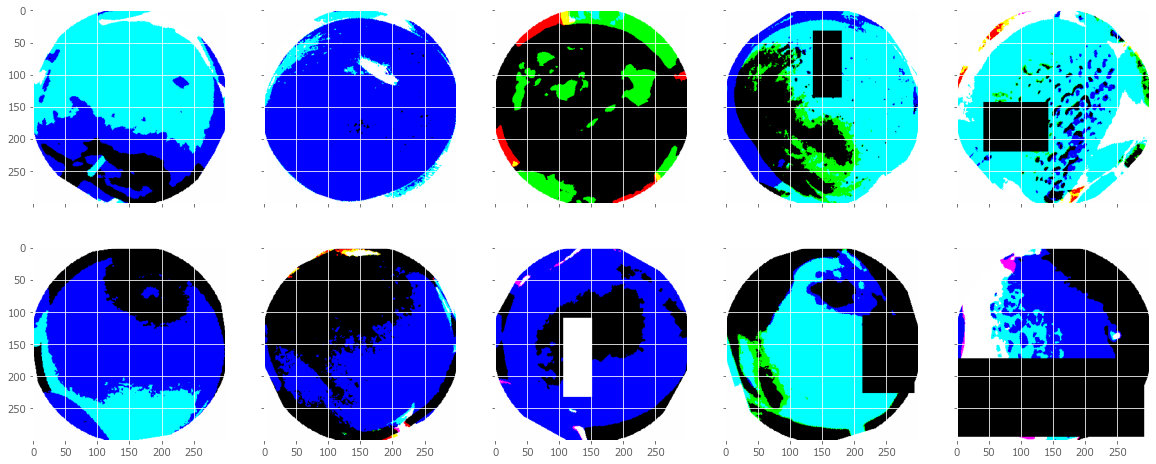

In [9]:
for i in range(1):
    i += 100
    Y_cat = to_categorical(Y_type)
    
    batch = bclearning_generator(datagen_train.flow(X,Y_cat, batch_size=10, seed=0),
                                 batch_size=10,
                                 sample_steps=10,
                                 n_steps=X.shape[0]//10)
    
    n,nrows,ncols = 0,2,5
    fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(20,8))
    for row in range(nrows):
        for col in range(ncols):
            x,y = next(batch)
            ax[row, col].imshow(np.uint8(x[0]))
            n += 1
#     print(x[0].sum())
#     print(x[0][0])
    plt.show()

In [10]:
def create_model(output_num, no_trainable_layer):
    base_model=EfficientNetB3(weights='imagenet',
                              include_top=False,
                              pooling="avg",
                              input_shape=(image_size,image_size,3))
    x = base_model.output
#     x = BatchNormalization()(x)
#     x = Flatten()(x)
    x = Dense(1024,activation='relu')(x)
    x = Dense(1024,activation='relu')(x)
    
#     x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    prediction = Dense(output_num, activation='softmax')(x)

    for layer in base_model.layers[:-no_trainable_layer]:
#     for layer in base_model.layers:    
        layer.trainable=False
    
    return Model(inputs=base_model.input,outputs=prediction)

In [11]:
# class FReLu(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(FReLu, self).__init__(**kwargs)
#         self.conv = Conv2D(filters=channels, kernel_size=3, padding="same")
#         self.bn = BatchNormalization()

#     def call(self, inputs):
#         return tf.math.maximum(inputs,self.bn(self.conv(inputs)))
    
class FReLu(tf.keras.layers.Layer):
    def __init__(self, channels, **kwargs):
        super(FReLu,self).__init__(**kwargs)
        self.conv = tf.keras.layers.Conv2D(filters=channels, kernel_size=3, padding="same")
        self.bn = BatchNormalization()

    def call(self, inputs):
#         return tf.math.maximum(inputs,self.bn(self.conv(inputs)))
        return tf.math.maximum(inputs,self.conv(inputs))
    
    
    def get_config(self):
        config = super(FReLu,self).get_config().copy()
        return config

In [12]:
# x = np.array(range(32)).reshape(1,4,4,2).astype("float32")
# FReLu(2)(x)

In [13]:
# FReLu(1).get_config()

In [14]:
# model.summary()

In [15]:
# def create_frelu_model(output_num,no_trainable_layer):
#     model = create_model(output_num,no_trainable_layer)

    
#     layer_num = len(model.layers)
#     merge_list = []
#     b_add_cash = [""]
#     b_add_list = []
#     c_add_list = []
#     d_add_list = []
#     e_add_list = []
    
#     for i, layer in enumerate(tqdm(model.layers)):
#         if i==0:
# #             print(i,":input:",layer)
#             input = layer.input
#             x = input
#         else:
#             if "activation" in layer.name:
#                 if i > layer_num - no_trainable_layer + 1000:
# #                     print(i,":activation_f:",layer.name)
#                     channels = x.shape[-1]
#                     merge_list.append(FReLu(channels)(x)) #m0
#                     x = FReLu(channels)(x)
#                 else:
# #                     print(i,":activation:",layer.name)
#                     merge_list.append(layer(x)) #m0
#                     x = layer(x)
# #                 print(i,":activation:",layer)
# #                 merge_list.append(layer(x)) #m0
# #                 x = layer(x)
#             elif "expand" in layer.name:
# #                 print(i,":expand:",layer)
#                 merge_list.append(layer(x)) #m1
#                 x = layer(x)
#             elif "drop" in layer.name:
# #                 print(i,":drop:",layer)
#                 b_add_list.append(layer(x)) #b0
#                 c_add_list.append(layer(x)) #c0
#                 d_add_list.append(layer(x)) #d0
#                 e_add_list.append(layer(x)) #e0
#                 x = layer(x)
#             elif "project_bn" in layer.name:
# #                 print(i,":project_bn:",layer)
#                 b_add_list.append(b_add_cash[-1]) #b1
#                 b_add_cash.append(layer(x))
#                 x = layer(x)
#             elif "b_add" in layer.name:
# #                 print(i,":b_add:",layer)
# #                 print(b_add_list[-2:])
#                 x = layer(b_add_list[-2:])
#                 c_add_list.append(layer(b_add_list[-2:])) #c1
#             elif "c_add" in layer.name:
# #                 print(i,":c_add:",layer)
# #                 print(c_add_list[-2:])
#                 x = layer(c_add_list[-2:])
#                 d_add_list.append(layer(c_add_list[-2:])) #d1
#             elif "d_add" in layer.name:
# #                 print(i,":d_add:",layer)
# #                 print(d_add_list[-2:])
#                 x = layer(d_add_list[-2:])
#                 e_add_list.append(layer(d_add_list[-2:])) #e1
#             elif "e_add" in layer.name:
# #                 print(i,":e_add:",layer)
# #                 print(e_add_list[-2:])
#                 x = layer(e_add_list[-2:])
#             elif "excite" in layer.name:
# #                 print(i,":excite(merge):",layer)
# #                 print(merge_list[-2:])
#                 x = layer(merge_list[-2:])
#             else:
# #                 print(i,":else:",layer)
#                 x = layer(x)
#     bn_model = Model(input, x)
#     return bn_model

In [16]:
# enet_frelu = create_frelu_model(46,70)

In [17]:
# enet_frelu.summary()

In [18]:
# from tensorflow.keras.utils import plot_model
# plot_model(
#     enet_frelu,
#     show_shapes=True,
# )

In [19]:
def accuracy_of_type(pred,true):
    acc_list = []
    
    true = np.array(true)
    pred = np.array(pred)
    
    acc_list.append(accuracy_score(true[true < 8],pred[true < 8]))
    acc_list.append(accuracy_score(true[(8 <= true) & (true < 14)],pred[(8 <= true) & (true < 14)]))
    acc_list.append(accuracy_score(true[(14 <= true) & (true < 22)],pred[(14 <= true) & (true < 22)]))
    acc_list.append(accuracy_score(true[(22 <= true) & (true < 30)],pred[(22 <= true) & (true < 30)]))
    acc_list.append(accuracy_score(true[(30 <= true) & (true < 36)],pred[(30 <= true) & (true < 36)]))
    acc_list.append(accuracy_score(true[(36 <= true) & (true < 41)],pred[(36 <= true) & (true < 41)]))
    acc_list.append(accuracy_score(true[(41 <= true) & (true < 46)],pred[(41 <= true) & (true < 46)]))
    
    return np.array(acc_list)

In [20]:
def model_train(X, Y, train_model=True, check_result=False, start_fold=0, bc_use=False, no_trainable_layer=70):
    np.set_printoptions(precision=4, floatmode='maxprec')
    
    acc_mean = 0
    acc_type_mean = np.zeros(7)
    error_set = set()
    
    X = X.astype("float32")
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    for fold, (train_index, test_index) in enumerate(skf.split(X,Y)):
        if fold<start_fold:
            continue
        
        print('#'*25)
        print('### FOLD %i'%(fold+1))
        print('#'*25)
        
        if fold == start_fold:
            Y_cat = to_categorical(Y)
        
        X_train = X[train_index]
        X_valid = X[test_index]
        Y_train = Y_cat[train_index]
        Y_valid = Y_cat[test_index]

        if train_model:
        
#             datagen_train.fit(X_train)
#             datagen_valid.fit(X_valid)
            
            model = create_model(len(set(Y)),no_trainable_layer)
#             model = create_frelu_model(len(set(Y)),no_trainable_layer)
        
            if bc_use:
                model.compile(loss="kullback_leibler_divergence", 
                              optimizer=Adam(lr=0.0005), 
                              metrics=['accuracy'])                
            else:
                model.compile(loss='categorical_crossentropy', 
                              optimizer=Adam(lr=0.0005), 
                              metrics=['accuracy'])
            
#             if fold == 0:
#                 model.summary()

            reduceLROnPlateau = ReduceLROnPlateau(monitor='val_accuracy',
                                                    patience=4, 
                                                    verbose=1, 
                                                    factor=0.5, 
                                                    min_lr=0.00001)

            modelCheckpoint = ModelCheckpoint(filepath = "model/model_" + str(fold) + ".h5",
                                                  monitor='val_accuracy',
                                                  verbose=0,
                                                  save_best_only=True,
                                                  period=1)

            earlyStopping = EarlyStopping(monitor='val_accuracy', patience=50, verbose=1, mode='max')

            if bc_use:
                datagen_train_bc = bclearning_generator(datagen_train.flow(X_train,Y_train, batch_size=BATCH_SIZE, seed=SEED),
                                                     BATCH_SIZE,
                                                     BATCH_SIZE,
                                                     X_train.shape[0]//BATCH_SIZE)

                hist = model.fit(datagen_train_bc,
                                 validation_data = datagen_valid.flow(X_valid,Y_valid, batch_size=BATCH_SIZE, seed=SEED),
                                 epochs = EPOCHS,
                                 verbose = 2,
                                 steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
                                 validation_steps = X_valid.shape[0] // BATCH_SIZE,
                                 callbacks = [reduceLROnPlateau,modelCheckpoint,earlyStopping]) 
            else:
                hist = model.fit(datagen_train.flow(X_train,Y_train, batch_size=BATCH_SIZE, seed=SEED),
                                 validation_data = datagen_valid.flow(X_valid,Y_valid, batch_size=BATCH_SIZE, seed=SEED),
                                 epochs = EPOCHS,
                                 verbose = 2,
                                 steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
                                 validation_steps = X_valid.shape[0] // BATCH_SIZE,
                                 callbacks = [reduceLROnPlateau,modelCheckpoint,earlyStopping])
        
        if check_result:
            model = load_model("model/model_" + str(fold) + ".h5", compile=False)

            #validをgeneratorから生成する。
            X_valid_temp = np.zeros(X_valid.shape)
            X_valid_image = X_valid
            for i in range(X_valid.shape[0]):
                temp = mask_circle_solid(X_valid[i])
                X_valid_temp[i] = preprocess_input(temp)
            X_valid = X_valid_temp

            pred = model.predict(X_valid)
            Y_pred_classes = argmax(pred, axis=1)
            Y_true = argmax(Y_valid , axis=1)

            ACC_pred = accuracy_score(Y_pred_classes, Y_true)
            acc_type = accuracy_of_type(Y_pred_classes, Y_true)
            cm = confusion_matrix(Y_pred_classes, Y_true)
            plt.figure(figsize=(10, 10)) 
            sns.heatmap(cm, annot=True, cmap='Blues', cbar=False)
            plt.show()
    #         Y_pred_classes = np.argmax(pred,axis = 1) 

            errors = (Y_pred_classes - Y_true != 0)
            error_set |= set(test_index[errors])
            pickle.dump(error_set,open("error_set.sav","wb"))

            #trainで当てられなかったデータはラベル自体が異なっている可能性あり
    #         X_train_temp = np.zeros(X_train.shape)
    #         for i in range(X_train.shape[0]):
    #             temp = mask_circle_solid(X_train[i])
    #             X_train_temp[i] = preprocess_input(temp)
    #         X_train = X_train_temp

    #         pred_train = model.predict(X_train)
    #         Y_pred_train_classes = argmax(pred_train, axis=1)
    #         Y_true_train = argmax(Y_train , axis=1)

    #         errors_train = (Y_pred_train_classes - Y_true_train != 0)
    #         error_train_set |= set(test_index[errors_train])
    #         pickle.dump(error_train_set,open("error_train_set.sav","wb"))


            #error top10
            Y_pred_classes_errors = Y_pred_classes[errors]
            Y_pred_errors = pred[errors]
            Y_true_errors = Y_true[errors]
            X_val_errors = X_valid_image[errors]/255

            def display_errors(errors_index, img_errors, pred_errors, obs_errors):
                n = 0
                nrows = 2
                ncols = 5
                fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(20, 8))
                for row in range(nrows):
                    for col in range(ncols):
                        error = errors_index[n]
                        ax[row, col].imshow((img_errors[error]).reshape((image_size, image_size,3)))
                        ax[row, col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error], obs_errors[error]))
                        n += 1
                plt.show()

            Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
            true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
            delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
            sorted_dela_errors = np.argsort(delta_pred_true_errors)
            most_important_errors = sorted_dela_errors[-10:]

            display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

            #shap
#             def map2layer(x, layer):
#                 feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
#                 return (model.layers[layer].input, feed_dict)
            
#             explainer = shap.DeepExplainer(
#                 (model.layers[layer].input, model.layers[-1].output),
#                 map2layer(X_train[0:100], 7),
#             )

#             #explainer = shap.DeepExplainer(model, (X_train[0:100]))
#             for i in most_important_errors:
#                 shap_values = explainer.shap_values(X_val_errors[[i]])
#                 index_names = np.array([str(x) + "\n" + '{:>7.3%}'.format(Y_pred_errors[i][x]) for x in range(output_num)]).reshape(1,output_num)
#                 print("Predicted label :{}\nTrue label :{}".format(Y_pred_classes_errors[i],Y_true_errors[i]))
                
#                 shap.image_plot(shap_values, X_val_errors[[i]] ,index_names)
#                 plt.gcf().set_size_inches(20, 20)

            acc_mean += ACC_pred/5
            acc_type_mean += acc_type/5
            print('val Acc =' , ACC_pred)
            print('val type Acc =', acc_type)
            print()
            del model
        del X_train
        del X_valid
        del Y_train
        del Y_valid
        
    print('#'*25)
    print('### RESULT')
    print('#'*25)
    print('>>>> Acc mean =', acc_mean)
    print('>>>> Acc type mean =', acc_type_mean)


#########################
### FOLD 1
#########################


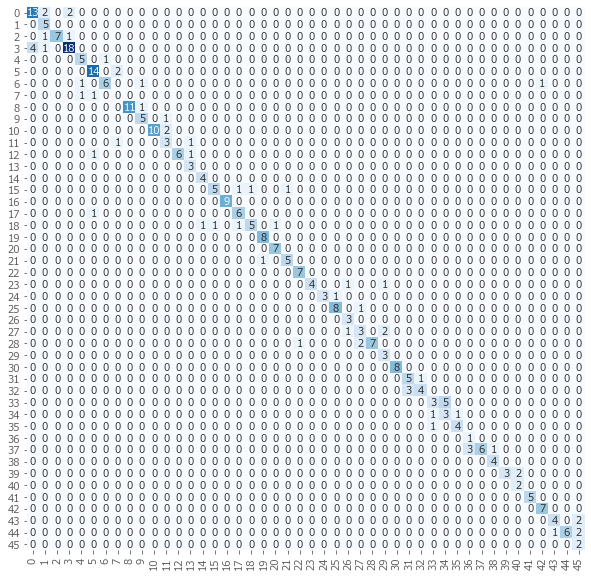

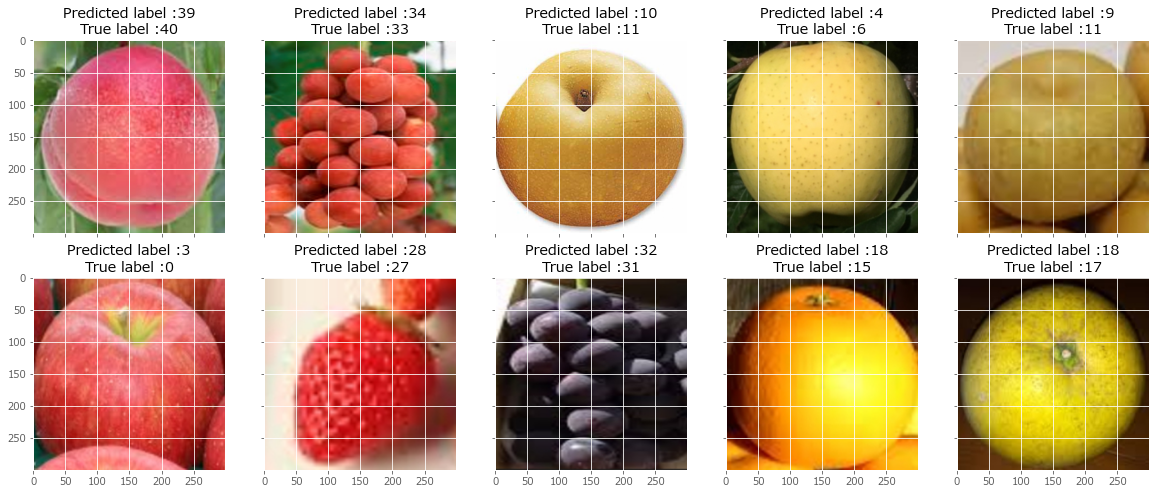

val Acc = 0.790273556231003
val type Acc = [0.7727 0.8444 0.8596 0.7917 0.6923 0.7273 0.8   ]

#########################
### FOLD 2
#########################


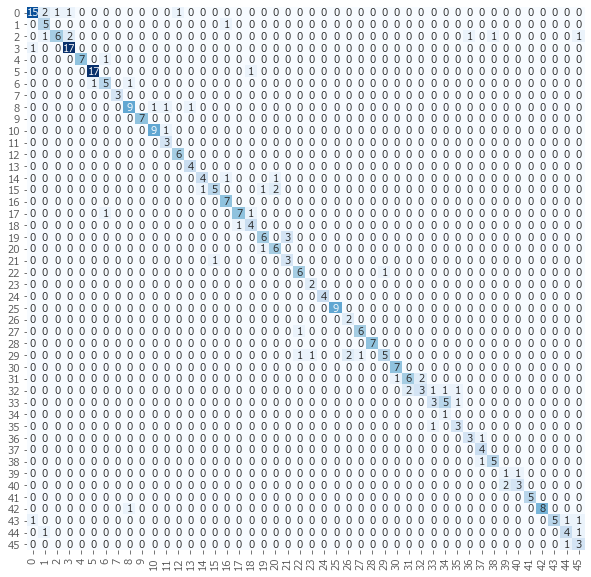

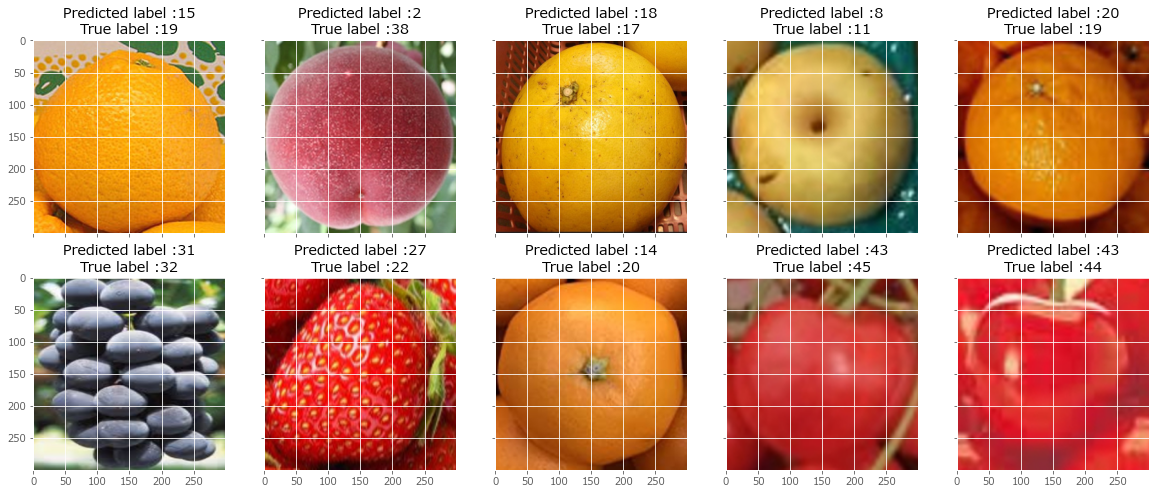

val Acc = 0.790273556231003
val type Acc = [0.8523 0.8444 0.7368 0.8542 0.6053 0.6957 0.8333]

#########################
### FOLD 3
#########################


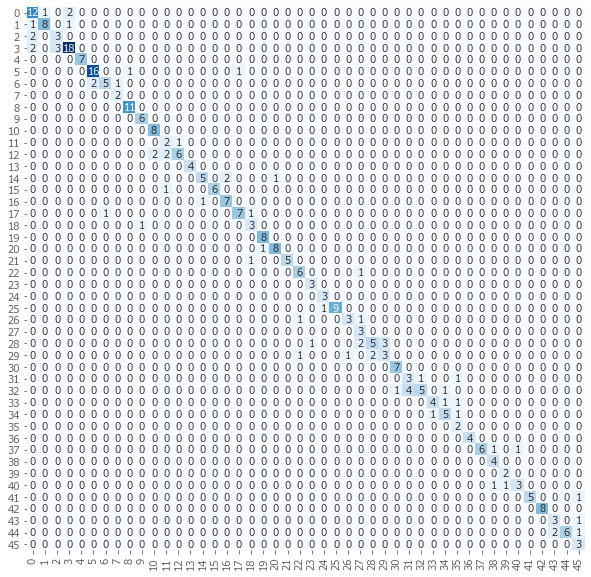

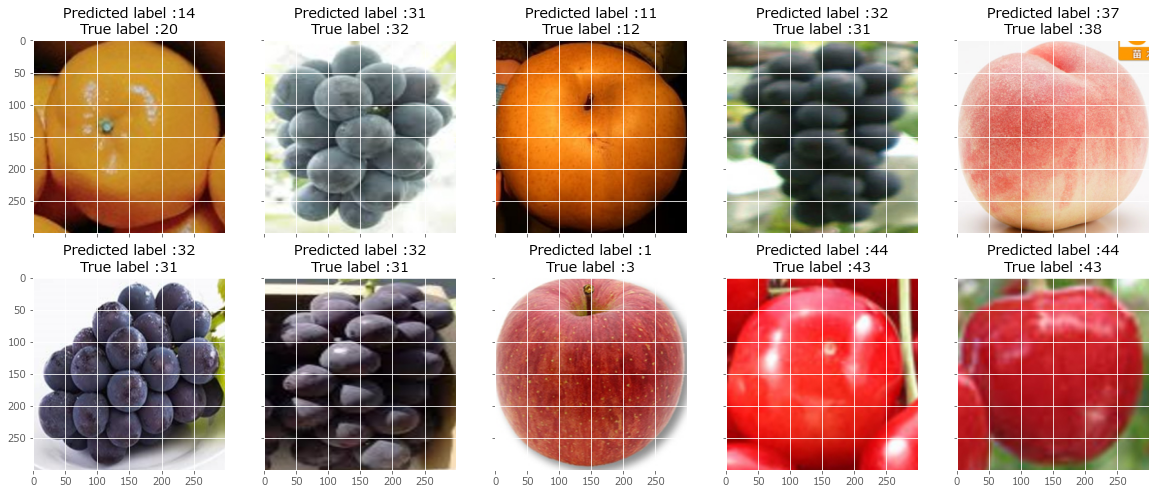

val Acc = 0.7963525835866262
val type Acc = [0.8161 0.8222 0.8596 0.7143 0.6842 0.8261 0.8333]

#########################
### FOLD 4
#########################


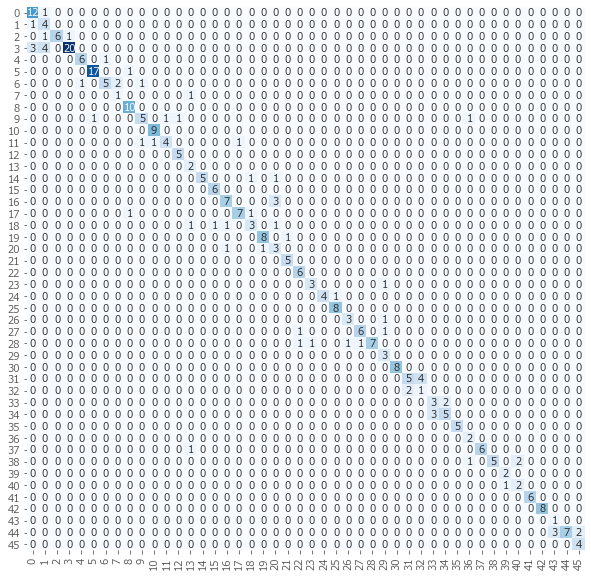

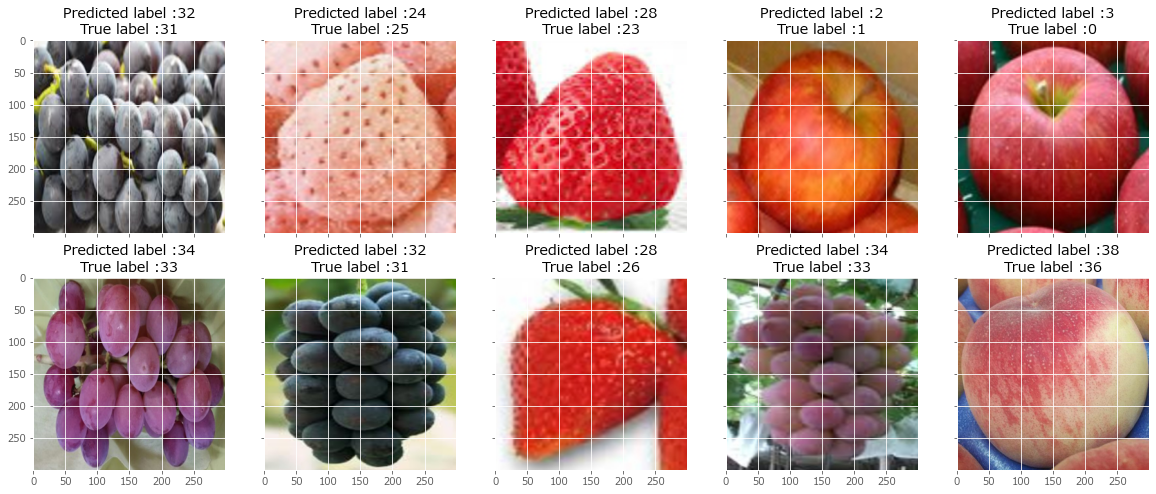

val Acc = 0.790273556231003
val type Acc = [0.8161 0.7778 0.7719 0.8163 0.7105 0.7727 0.8387]

#########################
### FOLD 5
#########################


In [ ]:
EPOCHS = 80
BATCH_SIZE = 16
SEED = 0

# X_one = X[np.where(Y_type==1)]
# Y_one = Y_variety[np.where(Y_type==1)]
# Y_one = Y_one - Y_one.min()

model_train(X, Y_variety, 
            train_model=False, 
            check_result=True, 
            start_fold=0,
            bc_use=True,
            no_trainable_layer=70)

In [26]:
model = load_model("model/model_0.h5", compile=False)

In [29]:
def map2layer(x, layer):
    a = model.layers[0].input
    b = preprocess_input(x.copy())
    feed_dict = dict(zip([a], [b]))
    return (model.layers[layer].input, feed_dict)
layer = 7
explainer = shap.DeepExplainer(
    (model.layers[layer].input, model.layers[-1].output),
    map2layer(X[0:100], layer),
)

#explainer = shap.DeepExplainer(model, (X_train[0:100]))
for i in most_important_errors:
    shap_values = explainer.shap_values(X_val_errors[[i]])
    index_names = np.array([str(x) + "\n" + '{:>7.3%}'.format(Y_pred_errors[i][x]) for x in range(output_num)]).reshape(1,output_num)
    print("Predicted label :{}\nTrue label :{}".format(Y_pred_classes_errors[i],Y_true_errors[i]))

    shap.image_plot(shap_values, X_val_errors[[i]] ,index_names)
    plt.gcf().set_size_inches(20, 20)
                

TypeError: Tensor is unhashable if Tensor equality is enabled. Instead, use tensor.experimental_ref() as the key.

In [35]:
model = create_model(5)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [15]:
X_valid = []
image1 = Image.open("./images_dif_/01/01 (12).jpg")
image1 = image1.convert("RGB")
image1 = image1.resize((image_size, image_size))
X_valid.append(np.array(image1))

image2 = Image.open("./images_dif_/01/01 (13).jpg")
image2 = image2.convert("RGB")
image2 = image2.resize((image_size, image_size))
X_valid.append(np.array(image2))

image3 = Image.open("./images_dif_/01/01 (14).jpg")
image3 = image3.convert("RGB")
image3 = image3.resize((image_size, image_size))
X_valid.append(np.array(image3))

In [16]:
X_valid[0][50][14]

array([255, 249, 253], dtype=uint8)

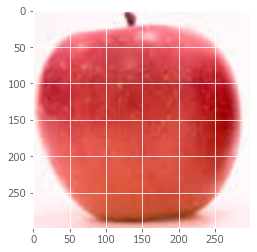

In [17]:
plt.imshow(X_valid[0])

In [18]:
X_valid_temp = np.zeros(np.array(X_valid).shape)
for i in range(np.array(X_valid).shape[0]):
    temp = mask_circle_solid(np.array(X_valid)[i])
    print(temp.sum())
    X_valid_temp[i] = preprocess_input(temp)
X_valid = X_valid_temp

model = load_model("model/model_" + str(0) + ".h5", compile=False)
pred = model.predict(X_valid)

30218511
27316350
29757504


In [19]:
X_valid[0].sum()

-31195.068254947662

In [20]:
pred

array([[1.9323660e-02, 3.2216203e-04, 3.3122296e-03, 7.2154514e-02,
        1.5020622e-02, 1.8516971e-02, 3.9518334e-04, 1.9345823e-04,
        6.7831293e-02, 1.4165277e-02, 1.1650074e-03, 1.2478725e-02,
        1.1219588e-02, 2.5303157e-02, 9.8753329e-03, 1.0652780e-01,
        1.0418666e-03, 4.6075108e-03, 2.3566835e-02, 3.4546770e-02,
        4.7047776e-03, 1.3220061e-02, 2.0301799e-04, 8.3420862e-05,
        1.8120643e-02, 2.2021818e-01, 4.0368692e-04, 2.2106610e-02,
        4.2887195e-03, 9.0942848e-03, 3.8521818e-04, 1.8758949e-02,
        1.8022156e-03, 1.2333341e-02, 2.0132498e-03, 6.3862529e-04,
        8.0907583e-02, 1.2097613e-02, 1.4141293e-02, 6.7341593e-03,
        3.9185081e-02, 2.2342909e-02, 3.5997722e-02, 1.5192387e-03,
        3.6975869e-03, 1.3433949e-02],
       [2.9801528e-04, 7.0354581e-05, 2.4435886e-03, 3.7000617e-01,
        5.6995609e-04, 4.7718678e-04, 5.8836453e-05, 8.4099756e-06,
        3.9848648e-03, 1.5930051e-04, 9.0986135e-04, 5.9625681e-04,
        1

In [21]:
argmax(pred, axis=1)

array([25,  3,  3], dtype=int64)